# Tutorial: Fermi GBM Trigger Method

The Fermi GBM onboard trigger method is responsible for identifying when astrophysical transients occur in GBM data. It creates the trigger times of GRB notices issued through the Global Coordinates Network (GCN). This tutorial walks through the application of GBM's onboard trigger method as defined in the Gamma-ray Data Tools (GDT) toolkit to triggered TTE data. 

**Disclaimer: the GDT implementation of the onboard trigger is a close, but not exact, approximation of the code running on the spacecraft. There may be small differences compared to triggers reported by the spacecraft. In particular, it does not implement 5 trigger algorithms optimized for detecting Terrestrial Gamma-ray Flashes (TGFs) that involve BGO detectors.**

The onboard trigger works by detecting when the count rate in two NaI detectors exceeds a certain threshold above the background level, given in units of standard deviation above the background. This is done using a set of sliding trigger windows, referred to as trigger algorithms, that sum detector counts over different timescales and energy ranges. The counts inside each trigger window are compared to background counts estimated over a 17 second long background window ending 4 seconds *before the end of of the trigger window*. The trigger time of each detection is defined as *the end time* of the first trigger window to detect the transient.

To begin, let's download some triggered TTE data for burst number 241212390. Note that we only need to download data for the NaI detectors.

In [1]:
from gdt.missions.fermi.gbm.finders import TriggerFinder

finder = TriggerFinder('241212390')

dets = ['n%d' % i for i in range(10)] + ['na', 'nb']
files = finder.get_tte(dets=dets, download_dir='.')

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

We can then open the files and store their content in a list

In [2]:
from gdt.missions.fermi.gbm.tte import GbmTte

ttes = [GbmTte.open(path) for path in files]

Great! Now let us take a quick look at the `GbmOnboardTrigger` class to see which trigger algorithms are defined

In [3]:
from gdt.missions.fermi.gbm.trigger import GbmOnboardTrigger

onboard_trig = GbmOnboardTrigger()
onboard_trig.algorithms

{1: TriggerAlgorithm(timescale   16 ms, offset    0 ms, channels [3, 4], threshold 7.50 sigma),
 2: TriggerAlgorithm(timescale   32 ms, offset    0 ms, channels [3, 4], threshold 7.50 sigma),
 3: TriggerAlgorithm(timescale   32 ms, offset   16 ms, channels [3, 4], threshold 7.50 sigma),
 4: TriggerAlgorithm(timescale   64 ms, offset    0 ms, channels [3, 4], threshold 5.00 sigma),
 5: TriggerAlgorithm(timescale   64 ms, offset   32 ms, channels [3, 4], threshold 5.00 sigma),
 6: TriggerAlgorithm(timescale  128 ms, offset    0 ms, channels [3, 4], threshold 5.00 sigma),
 7: TriggerAlgorithm(timescale  128 ms, offset   64 ms, channels [3, 4], threshold 5.00 sigma),
 8: TriggerAlgorithm(timescale  256 ms, offset    0 ms, channels [3, 4], threshold 4.00 sigma),
 9: TriggerAlgorithm(timescale  256 ms, offset  128 ms, channels [3, 4], threshold 4.00 sigma),
 10: TriggerAlgorithm(timescale  512 ms, offset    0 ms, channels [3, 4], threshold 4.00 sigma),
 11: TriggerAlgorithm(timescale  512 ms

You can see from the output above that a number of algorithms are implemented using different timescales and energy ranges. The fields displayed for these algorithms are:
* **timescale** The time window over which we compute detector counts. You can think of it as the duration of a potential transient. It is defined using an integer number of milliseconds.
* **offset** The starting point of the first time window relative to the beginning of TTE data. For example, 256 ms means the first trigger window will start 256 ms after the earliest photon event and extend to 256 ms + **timescale**. The next window will begin at 256 ms + **timescale** and proceed from there. This value is also defined in integer milliseconds
* **channels** The range of energy channels to use when summing detector counts. Most algorithms use [3, 4] which is approximately 50-300 keV.
* **threshold** The threshold level used to determine which detectors contribute to the trigger in units of significance above background. The threshold is set higher for shorter timescales in order to suppress false detections arising from the additional trials incurred when scanning smaller time windows through the data in increments of the window duration.

We will now apply these algorithms to our TTE data using `prepare_data()` to perform the necessary binning in time and energy. This is followed by `apply_trigger()`, which loops to step the time window for each algorithm through the full set of TTE data in increments of **timescale**. In this way, each algorithm is effectively a series of adjacent, non-overlapping measurements of the count rate.

In [4]:
onboard_trig.prepare_data(ttes)
triggers = onboard_trig.apply_trigger()
triggers[0]

Output()

Output()

Trigger <algorithm num 14, timescale 2048 ms, time 0.0 s, triggered det ['n9', 'na']>

It looks like the first trigger we found is for algorithm number 14, which has a timescale of 2048 ms. It occured at t = 0.0 seconds relative to the trigger time of the TTE data. This makes sense since that trigger time of our TTE data was determined by the same trigger method onboard the spacecraft. We can now take a look at the two detectors contributing to the trigger, n9 and na, by using the lightcurve plotting method of the `GbmOnboardTrigger` class

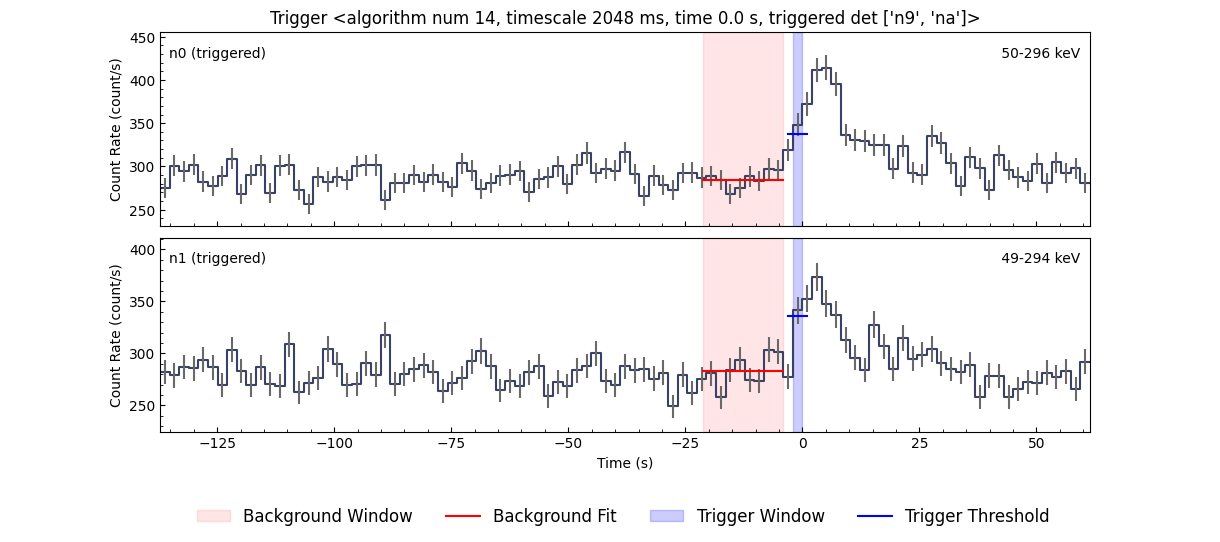

In [5]:
fig, axes, lcplots = onboard_trig.lightcurve_plot(triggers[0], detectors=triggers[0].triggered_det_num)

In this case we can see that the count rate in both detectors exceeds the trigger threshold marked by the dark blue line. This threshold is computed relative to the background measured over the 17 second long window highlighted in red.

We can verify that no other detectors exceed this threshold by plotting the lightcurves from all detectors

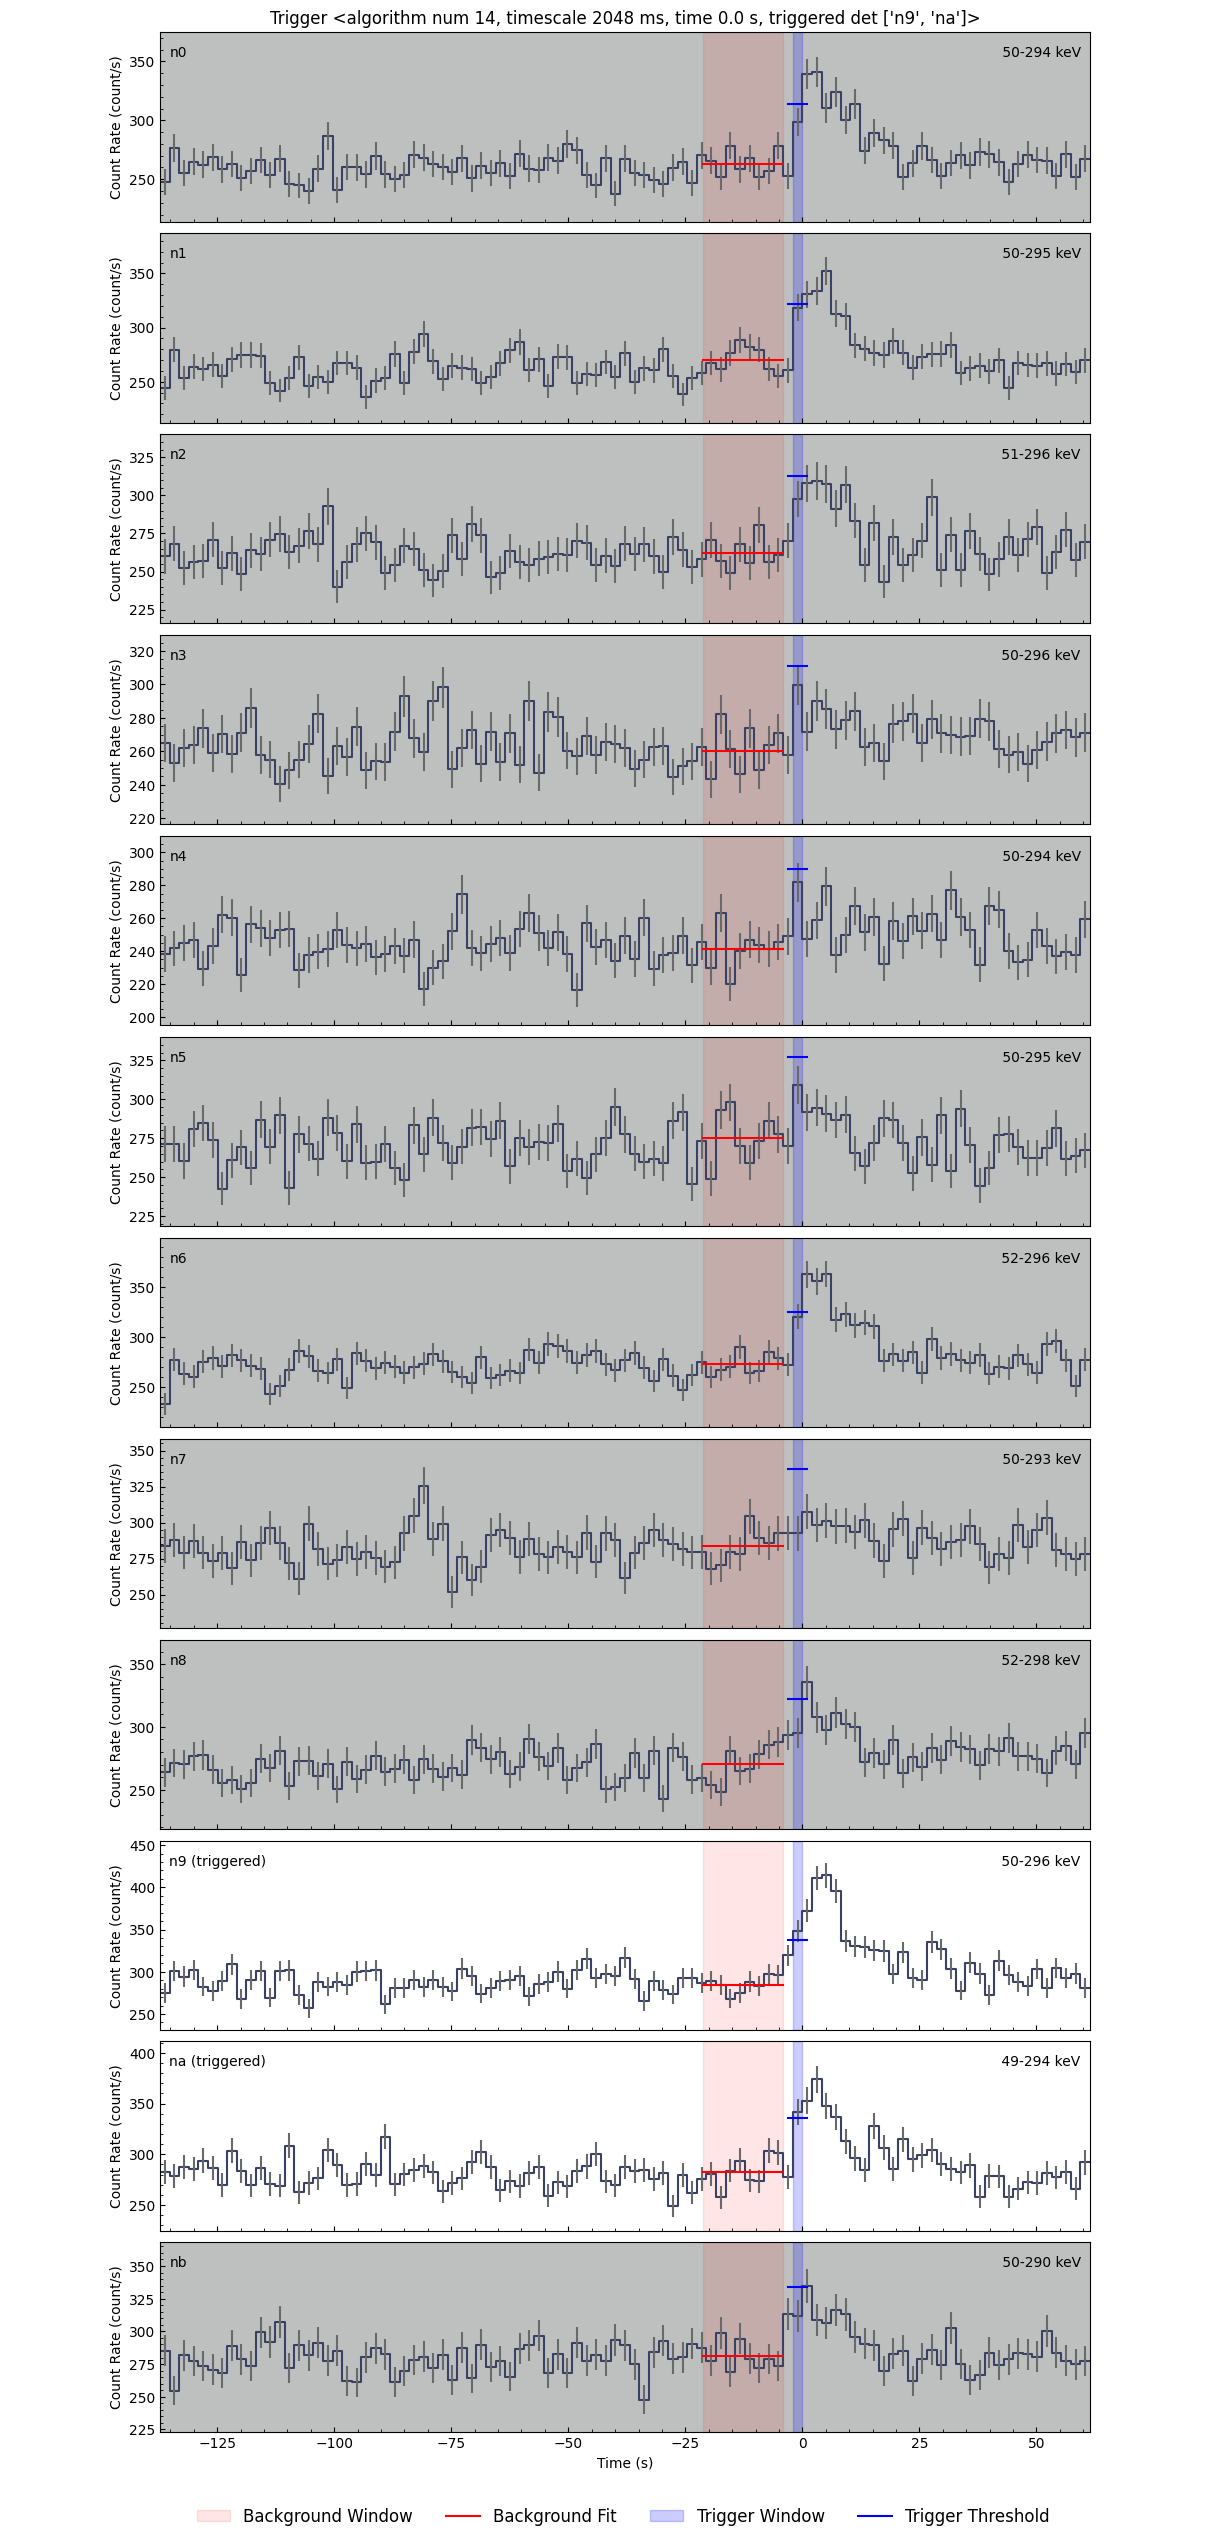

In [6]:
fig, axes, lcplots = onboard_trig.lightcurve_plot(triggers[0])

We can also use the `waterfall_plot()` method to display the full set of trigger algorithms that exceed the trigger threshold. Each trigger window with a transient detection is shown as a box on a plot of algorithm number versus time. The width of each box is the timescale of the trigger algorithm. 

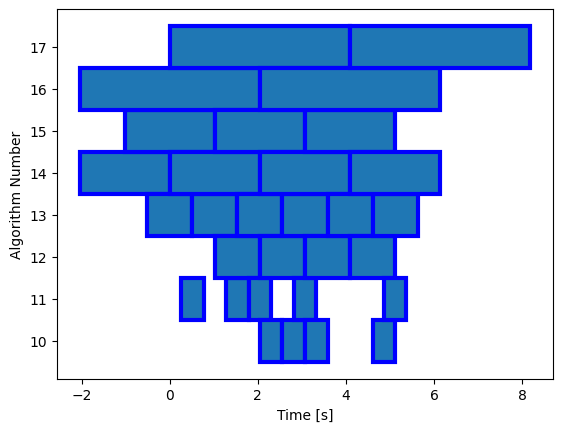

In [7]:
rects = onboard_trig.waterfall_plot(triggers)

From this we can easily see adjacent trigger windows that find the same transient as well as the phase shift introduced by the **offset** parameter for algorithms with the same **timescale**, such as algorithms 16 & 17.

It's also nice to highlight the first trigger window, which is the one that would generate a GCN notice.

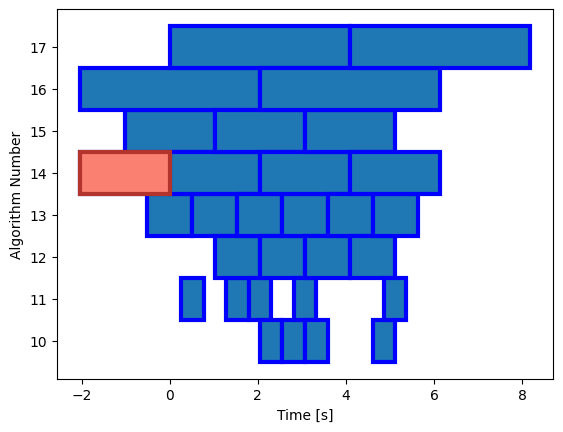

In [8]:
rects = onboard_trig.waterfall_plot(triggers)
rects0 = onboard_trig.waterfall_plot([triggers[0]], facecolor='#FA8072', edgecolor='#B2342D', linewidth=3)

One can also retrieve the set of trigger windows that result in a GCN notice by applying the 300 second time holdoff used to differentiate between duplicate transient triggers onboard the spacecraft

In [9]:
selected = onboard_trig.apply_holdoff(triggers, holdoff=300)
selected

[Trigger <algorithm num 14, timescale 2048 ms, time 0.0 s, triggered det ['n9', 'na']>]

Users who want to apply their own trigger algorithms can define them using the `TriggerAlgorithm` class. These should be formatted as values in a dictionary passed to the `GbmOnboardTrigger.algorithms` property.

Note: we don't need to run `prepare_data()` again when updating the trigger algorithms. This step is only needed if you want to change the TTE data.

In [10]:
from gdt.missions.fermi.gbm.trigger.algorithms import TriggerAlgorithm

algs = {
    1: TriggerAlgorithm(timescale=2048, offset=0,    channels=(3, 4), threshold=4.5),
    2: TriggerAlgorithm(timescale=2048, offset=256,  channels=(3, 4), threshold=4.5),
    3: TriggerAlgorithm(timescale=2048, offset=512,  channels=(3, 4), threshold=4.5),
    4: TriggerAlgorithm(timescale=2048, offset=768,  channels=(3, 4), threshold=4.5),
    5: TriggerAlgorithm(timescale=2048, offset=1024, channels=(3, 4), threshold=4.5),
    6: TriggerAlgorithm(timescale=2048, offset=1280, channels=(3, 4), threshold=4.5),
    7: TriggerAlgorithm(timescale=2048, offset=1536, channels=(3, 4), threshold=4.5),
    8: TriggerAlgorithm(timescale=2048, offset=1792, channels=(3, 4), threshold=4.5)
}

onboard_trig.algorithms = algs # update algorithms, algs can also be passed to the constructor

triggers = onboard_trig.apply_trigger()
triggers[0]

Output()

Trigger <algorithm num 1, timescale 2048 ms, time 0.0 s, triggered det ['n9', 'na']>

As a final exercise, we can display the waterfall plot of triggers identified by our custom algorithms.

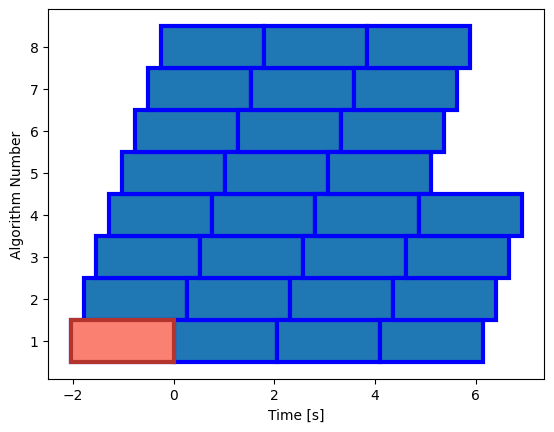

In [11]:
rects = onboard_trig.waterfall_plot(triggers)
rects0 = onboard_trig.waterfall_plot([triggers[0]], facecolor='#FA8072', edgecolor='#B2342D', linewidth=3)